# Relocation

In the previous notebook, `5_backprojection`, we built a database of events detected with the backprojection technique. Here, we will improve the location of each of these events by using a more elaborated location technique.

In [1]:
import os
# choose the number of threads you want to limit the computation to
n_CPUs = 24
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)

import copy
import BPMF
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

from BPMF.data_reader_examples import data_reader_mseed
from time import time as give_time

%config InlineBackend.figure_formats = ["svg"]
plt.rcParams["svg.fonttype"] = "none"

In [2]:
INPUT_DB_FILENAME = "raw_bp.h5"
OUTPUT_DB_FILENAME = "reloc_bp.h5"
OUTPUT_CSV_FILENAME = "backprojection_catalog.csv"
NETWORK_FILENAME = "network.csv"

In [3]:
net = BPMF.dataset.Network(NETWORK_FILENAME)
net.read()

## Load the metadata of the events previously detected with backprojection

In the previous notebook, we used `BPMF.dataset.Event.write` to save the metadata of each detected event to a hdf5 database. Here, we will use `BPMF.dataset.Event.read_from_file` to read the metadata and build a list of `BPMF.dataset.Event` instances.

In [4]:
backprojection_events = []
with h5.File(os.path.join(BPMF.cfg.OUTPUT_PATH, INPUT_DB_FILENAME), mode="r") as fin:
    print(f"Each event's metadata is stored at a 'subfolder'. The subfolders are: {fin.keys()}")
    print("In hdf5, 'subfolders' are called 'groups'.")
    for group_id in fin.keys():
        backprojection_events.append(
            BPMF.dataset.Event.read_from_file(
                INPUT_DB_FILENAME,
                db_path=BPMF.cfg.OUTPUT_PATH,
                gid=group_id,
                data_reader=data_reader_mseed
            )
        )

Each event's metadata is stored at a 'subfolder'. The subfolders are: <KeysViewHDF5 ['20120726_011024', '20120726_011555', '20120726_015757', '20120726_023502', '20120726_030040', '20120726_044339', '20120726_044840', '20120726_080827', '20120726_100725', '20120726_115536', '20120726_133527', '20120726_134834', '20120726_135200', '20120726_135333', '20120726_135656', '20120726_150621', '20120726_172821']>
In hdf5, 'subfolders' are called 'groups'.


In [5]:
initial_catalog = pd.DataFrame(columns=["origin_time", "longitude", "latitude", "depth"])
for i, ev in enumerate(backprojection_events):
    initial_catalog.loc[i, "origin_time"] = ev.origin_time
    initial_catalog.loc[i, "longitude"] = ev.longitude
    initial_catalog.loc[i, "latitude"] = ev.latitude
    initial_catalog.loc[i, "depth"] = ev.depth
initial_catalog["origin_time"] = initial_catalog["origin_time"].values.astype("datetime64[ms]")
initial_catalog["longitude"] = initial_catalog["longitude"].values.astype("float32")
initial_catalog["latitude"] = initial_catalog["latitude"].values.astype("float32")
initial_catalog["depth"] = initial_catalog["depth"].values.astype("float32")
initial_catalog

,origin_time,longitude,latitude,depth
0,2012-07-26 01:10:24.040,30.320000,40.730000,12.0
1,2012-07-26 01:15:55.840,30.379999,40.709999,7.0
2,2012-07-26 01:57:57.240,30.230000,40.630001,-0.5
3,2012-07-26 02:35:02.920,30.330000,40.720001,7.0
4,2012-07-26 03:00:40.840,30.330000,40.720001,9.5
5,2012-07-26 04:43:39.280,30.360001,40.720001,0.0
6,2012-07-26 04:48:40.360,30.350000,40.720001,9.0
7,2012-07-26 08:08:27.360,30.340000,40.720001,9.0
8,2012-07-26 10:07:25.440,30.340000,40.720001,10.0
9,2012-07-26 11:55:36.640,30.290001,40.619999,0.0


Build a `BPMF.dataset.Catalog` instance from `initial_catalog` in order to benefit from the `BPMF.dataset.Catalog` plotting methods.

In [6]:
initial_catalog = BPMF.dataset.Catalog.read_from_dataframe(
    initial_catalog,
)

In [7]:
initial_catalog.catalog

,longitude,latitude,depth,origin_time
0,30.320000,40.730000,12.0,2012-07-26 01:10:24.040
1,30.379999,40.709999,7.0,2012-07-26 01:15:55.840
2,30.230000,40.630001,-0.5,2012-07-26 01:57:57.240
3,30.330000,40.720001,7.0,2012-07-26 02:35:02.920
4,30.330000,40.720001,9.5,2012-07-26 03:00:40.840
5,30.360001,40.720001,0.0,2012-07-26 04:43:39.280
6,30.350000,40.720001,9.0,2012-07-26 04:48:40.360
7,30.340000,40.720001,9.0,2012-07-26 08:08:27.360
8,30.340000,40.720001,10.0,2012-07-26 10:07:25.440
9,30.290001,40.619999,0.0,2012-07-26 11:55:36.640


Let's plot the locations that the backprojection method produced.

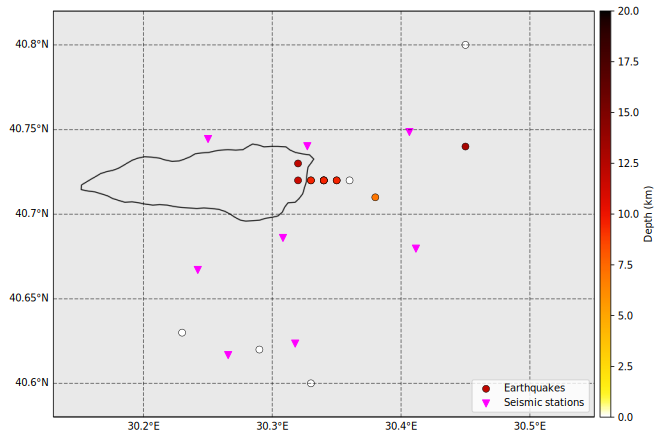

In [8]:
fig = initial_catalog.plot_map(figsize=(10, 10), network=net, s=50, markersize_station=50, lat_margin=0.02)
ax = fig.get_axes()[0]
ax.set_facecolor("dimgrey")
ax.patch.set_alpha(0.15)

The backprojection method offers several advantages for locating earthquakes:
- Locations come for free in addition to detecting events.
- The "picking" of P and S waves does not involve any single-channel threshold.
- Backprojection effectively solves the detection and phase association problems at the same time.

However, there is a number of cons:
- The backprojection locations are just as good as the grid is. If a downsampled grid was used for computation efficiency, then the locations definitely need to be refined.
- It is hard and computationally expensive to estimate uncertainties (as we will see later in this notebook).

Thus, in the following, we will explore two ways to refine the initial locations.

## Relocation 1: PhaseNet picks and NonLinLoc

If you have installed `PhaseNet` and `NonLinLoc`, you can use `BPMF.dataset.Event` methods to easily relocate events with automatic picking and earthquake location. This is a two-step procedure. We first need to pick the P- and S-wave arrivals with `PhaseNet` before giving these data to `NonLinLoc`.

We will explore, step by step, what happens to the `BPMF.dataset.Event` instance when picking the phase arrivals and when relocating with `NonLinLoc`. First, we read short windows around the P- and S-wave arrivals, as determined by the backprojection locations.

### Automated picking and relocation

In [9]:
# event extraction parameters

# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "P"}
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 1.0, "S": 4.0}
# TIME_SHIFTED: boolean, if True, use moveouts to extract relevant windows
TIME_SHIFTED = True
# DATA_FOLDER: name of the folder where the waveforms we want to use for picking are stored
DATA_FOLDER = "preprocessed_2_12"

In [10]:
t1 = give_time()
for i in range(len(backprojection_events)):
    backprojection_events[i].read_waveforms(
        BPMF.cfg.TEMPLATE_LEN_SEC,
        phase_on_comp=PHASE_ON_COMP,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
    )
t2 = give_time()
print(
    f"{t2-t1:.2f}sec to read the waveforms for all {len(backprojection_events):d} detections."
)

4.21sec to read the waveforms for all 17 detections.


Let's plot these short windows with `BPMF.dataset.Event.plot`.

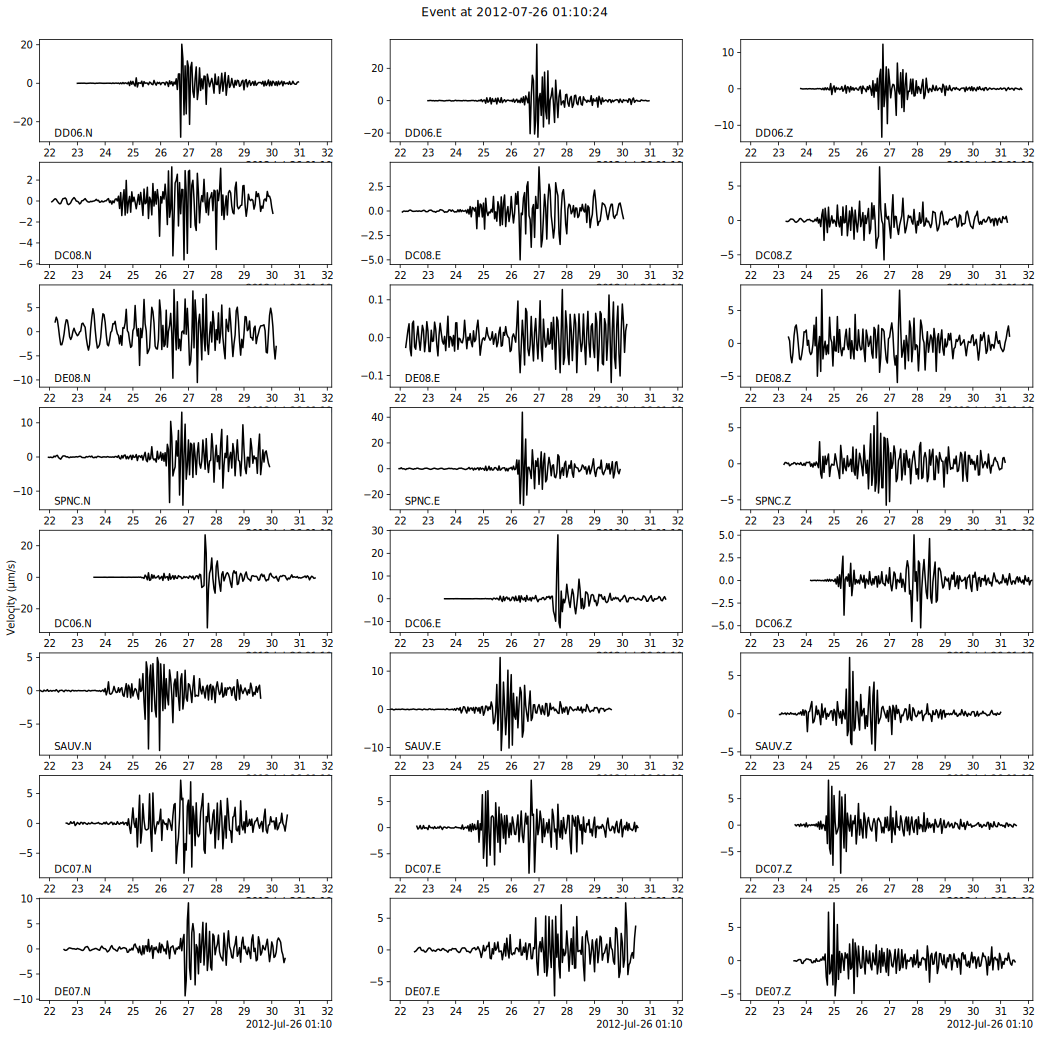

In [11]:
# play with EVENT_IDX to plot different events
EVENT_IDX = 0
fig = backprojection_events[EVENT_IDX].plot(figsize=(15, 15))

Now, we will use `PhaseNet` to pick the P- and S-wave arrivals. This is done with the `BPMF.dataset.Event.pick_PS_phases` method.

In [12]:
# PhaseNet picking parameters

# PhaseNet was trained for 100Hz data. Even if we saw that running PhaseNet on 25Hz data
# was good for backprojection, here, picking benefits from running PhaseNet on 100Hz data.
# Thus, we will upsample the waveforms before running PhaseNet.
PHASENET_SAMPLING_RATE_HZ = 100.
UPSAMPLING_BEFORE_PN_RELOCATION = int(PHASENET_SAMPLING_RATE_HZ/BPMF.cfg.SAMPLING_RATE_HZ)
DOWNSAMPLING_BEFORE_PN_RELOCATION = 1

# DURATION_SEC: the duration, in seconds, of the data stream starting at the detection time
#               defined by Event.origin_time. This data stream is used for picking the P/S waves.
DURATION_SEC = 60.0
# THRESHOLD_P: probability of P-wave arrival above which we declare a pick. If several picks are
#              declared during the DURATION_SEC data stream, we only keep the best one. We can
#              afford using a low probability threshold since we already know with some confidence
#              that an earthquake is in the data stream.
THRESHOLD_P = 0.10
# THRESHOLD_S: probability of S-wave arrival above which we declare a pick.
THRESHOLD_S = 0.10
# DATA_FOLDER: name of the folder where the waveforms we want to use for picking are stored
DATA_FOLDER = "preprocessed_2_12"
# COMPONENT_ALIASES: A dictionary that defines the possible channel names to search for
#                    for example, the seismometer might not be oriented and the horizontal channels
#                    might be named 1 and 2, in which case we arbitrarily decide to take 1 as the "N" channel
#                    and 2 as the "E" channel. This doesn't matter for picking P- and S-wave arrival times.
COMPONENT_ALIASES = {"N": ["N", "1"], "E": ["E", "2"], "Z": ["Z"]}
# USE_APRIORI_PICKS: boolean. This option is IMPORTANT when running BPMF in HIGH SEISMICITY CONTEXTS, like
#                   during the aftershock sequence of a large earthquake. If there are many events happening
#                   close to each other in time, we need to guide PhaseNet to pick the right set of picks.
#                   For that, we use the predicted P- and S-wave times from backprojection to add extra weight to
#                   the picks closer to those times and make it more likely to identify them as the "best" picks.
#                   WARNING: If there are truly many events, even this trick might fail. It's because "phase association"
#                   is an intrinsically hard problem in this case, and the picking might be hard to do automatically.
USE_APRIORI_PICKS = True

In [13]:
for i in range(len(backprojection_events)):
    print(f"Picking P and S wave arrivals on detection {i:d}")
    # make sure the event's station list has all the stations at which
    # we eventually want travel times after NLLoc's location
    backprojection_events[i].stations = net.stations.values.astype("U")
    # the following line should only be used in a similar context as here
    # it uses the moveouts from the backprojection location to define the
    # P/S arrival times that we use a "prior information"
    backprojection_events[i].set_arrival_times_from_moveouts()
    backprojection_events[i].pick_PS_phases(
        DURATION_SEC,
        threshold_P=THRESHOLD_P,
        threshold_S=THRESHOLD_S,
        component_aliases=COMPONENT_ALIASES,
        data_folder=DATA_FOLDER,
        upsampling=UPSAMPLING_BEFORE_PN_RELOCATION,
        downsampling=DOWNSAMPLING_BEFORE_PN_RELOCATION,
        use_apriori_picks=USE_APRIORI_PICKS,
    )

Picking P and S wave arrivals on detection 0
Make sure origin_time + moveout points at the phase arrival!
Picking P and S wave arrivals on detection 1
Make sure origin_time + moveout points at the phase arrival!
Picking P and S wave arrivals on detection 2
Make sure origin_time + moveout points at the phase arrival!
Picking P and S wave arrivals on detection 3
Make sure origin_time + moveout points at the phase arrival!
Picking P and S wave arrivals on detection 4
Make sure origin_time + moveout points at the phase arrival!
Picking P and S wave arrivals on detection 5
Make sure origin_time + moveout points at the phase arrival!
Picking P and S wave arrivals on detection 6
Make sure origin_time + moveout points at the phase arrival!
Picking P and S wave arrivals on detection 7
Make sure origin_time + moveout points at the phase arrival!
Picking P and S wave arrivals on detection 8
Make sure origin_time + moveout points at the phase arrival!
Picking P and S wave arrivals on detection 9
M

We are done with the automatic picking! Every instance of `BPMF.dataset.Event` should now have a new attribute `picks`.

In [14]:
EVENT_IDX = 0
backprojection_events[EVENT_IDX].picks

,P_picks_sec,P_probas,P_abs_picks,S_picks_sec,S_probas,S_abs_picks
stations,,,,,,
DD06,20.610001,0.488124,2012-07-26T01:10:24.650001Z,22.620001,0.934778,2012-07-26T01:10:26.660001Z
DC08,20.330000,0.643466,2012-07-26T01:10:24.370000Z,22.209999,0.720806,2012-07-26T01:10:26.249999Z
DE08,19.990000,0.405078,2012-07-26T01:10:24.030000Z,22.270000,0.516951,2012-07-26T01:10:26.310000Z
SPNC,20.379999,0.913320,2012-07-26T01:10:24.419999Z,22.250000,0.904806,2012-07-26T01:10:26.290000Z
DC06,20.910000,0.241919,2012-07-26T01:10:24.950000Z,23.450001,0.859720,2012-07-26T01:10:27.490001Z
SAUV,19.889999,0.823232,2012-07-26T01:10:23.929999Z,21.379999,0.814035,2012-07-26T01:10:25.419999Z
DC07,20.389999,0.213719,2012-07-26T01:10:24.429999Z,22.490000,0.716496,2012-07-26T01:10:26.530000Z
DE07,20.670000,0.971315,2012-07-26T01:10:24.710000Z,22.809999,0.901983,2012-07-26T01:10:26.849999Z


These picks are automatically read when calling `BPMF.dataset.Event.plot`. Before plotting the waveforms with the newly obtained picks, let's re-read the waveforms in the same format as before for the sake of easier visualization.

In [15]:
t1 = give_time()
for i in range(len(backprojection_events)):
    backprojection_events[i].read_waveforms(
        BPMF.cfg.TEMPLATE_LEN_SEC,
        phase_on_comp=PHASE_ON_COMP,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
    )
t2 = give_time()
print(
    f"{t2-t1:.2f}sec to read the waveforms for all {len(backprojection_events):d} detections."
)

4.34sec to read the waveforms for all 17 detections.


The following plot shows the PhaseNet picks with dashed vertical lines (blue=P-wave, red=S-wave) and the arrival times predicted by the backprojection location with solid vertical lines (purple=P-wave, orange=S-wave). See how, in this tutorial, the backprojection locations already do a good job at predicting the P- and S-wave times... given the limitations of the 1D velocity model.

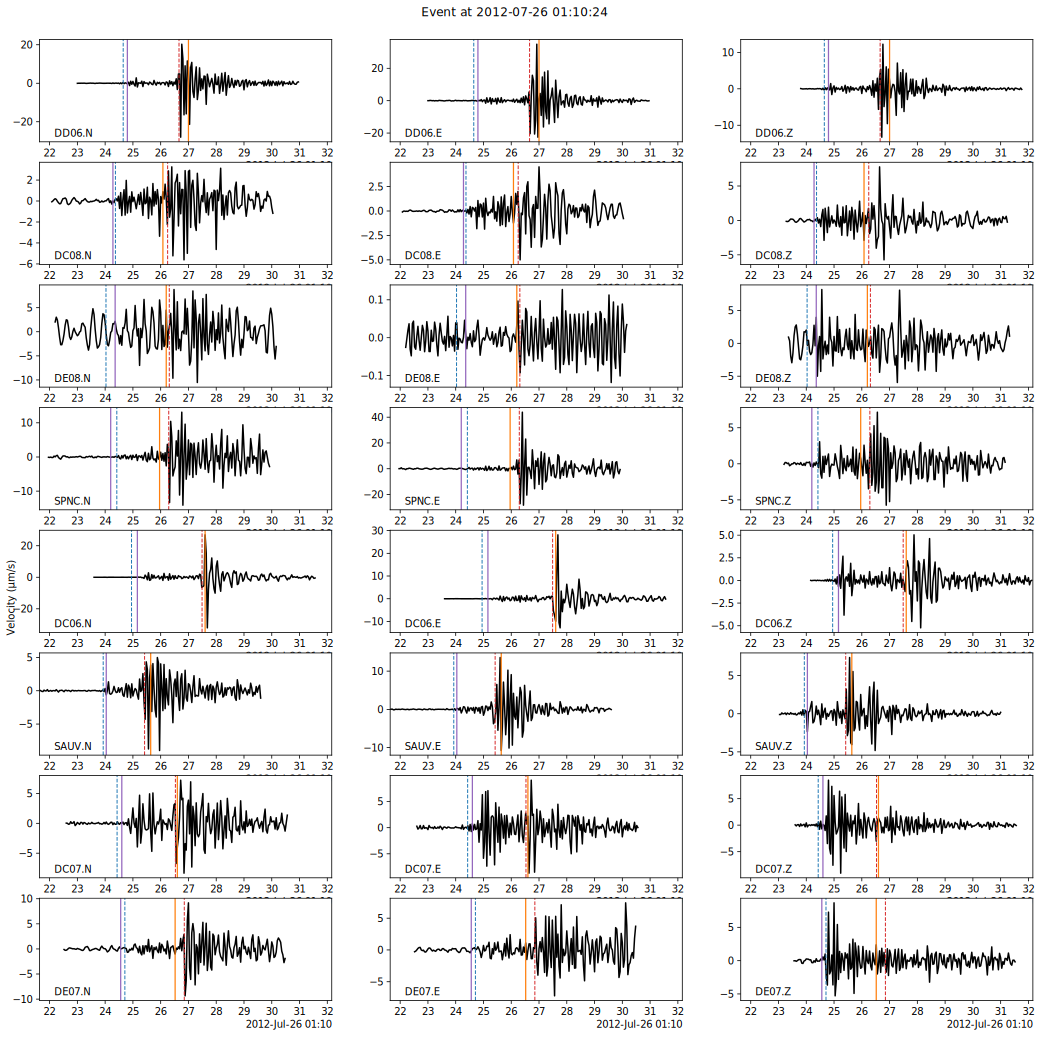

In [16]:
# play with EVENT_IDX to plot different events
EVENT_IDX = 0
fig = backprojection_events[EVENT_IDX].plot(figsize=(15, 15))

We now are all set for using our favorite location software using PhaseNet's picks. We can use `NLLoc` with one of `BPMF.dataset.Event` methods. See http://alomax.free.fr/nlloc/ for more info.

In [17]:
# location parameters

LOCATION_ROUTINE = "NLLoc"
# NLLOC_METHOD: string that defines what loss function is used by NLLoc, see http://alomax.free.fr/nlloc/ for more info.
#               Using some flavor of 'EDT' is important to obtain robust locations that are not sensitive to pick outliers.
NLLOC_METHOD = "EDT"
# MINIMUM_NUM_STATIONS_W_PICKS: minimum number of stations with picks to even try relocation.
MINIMUM_NUM_STATIONS_W_PICKS = 3

In [18]:
for i, ev in enumerate(backprojection_events):
    # before relocating, let's store the old location for book-keeping
    ev.set_aux_data(
        {"backprojection_longitude": ev.longitude,
         "backprojection_latitude": ev.latitude,
         "backprojection_depth": ev.depth}
    )
    if len(ev.picks.dropna(how="all")) >= MINIMUM_NUM_STATIONS_W_PICKS:
        print(f"Relocating event {i}")
        # first relocation, insensitive to outliers
        ev.relocate(
            stations=net.stations, routine=LOCATION_ROUTINE, method=NLLOC_METHOD,
        )

Relocating event 0
Relocating event 1
Relocating event 2
Relocating event 3
Relocating event 4
Relocating event 5
Relocating event 6
Relocating event 7
Relocating event 8
Relocating event 9
Relocating event 10
Relocating event 11
Relocating event 12
Relocating event 13
Relocating event 14
Relocating event 15
Relocating event 16


Let's plot the updated predicted times!

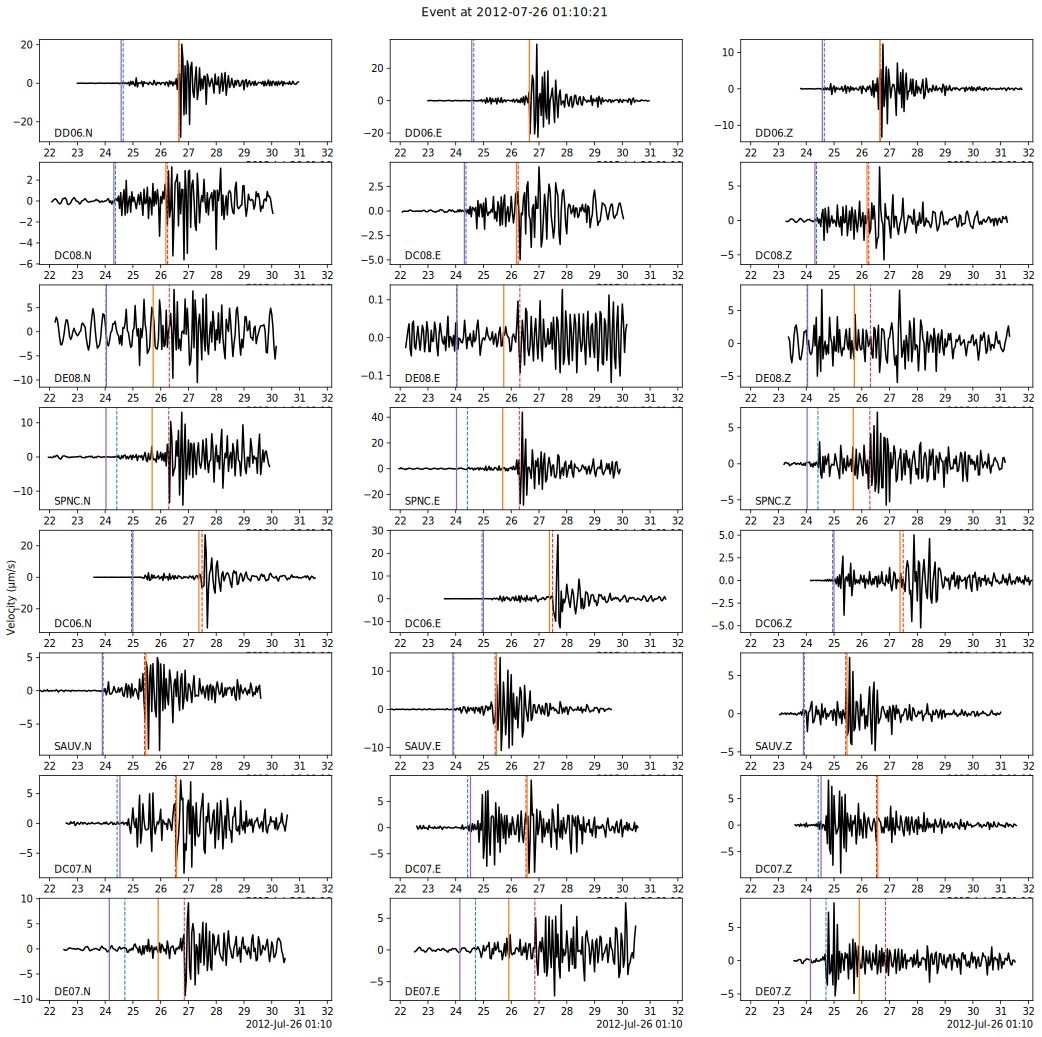

In [19]:
# play with EVENT_IDX to plot different events
EVENT_IDX = 0
fig = backprojection_events[EVENT_IDX].plot(figsize=(15, 15))

It doesn't look like much has changed... But we now have the location uncertainties. The uncertainty information is encoded in the covariance matrix, which is stored at `BPMF.dataset.Event.aux_data["cov_mat"]`.

In [20]:
EVENT_IDX = 0
ev = backprojection_events[EVENT_IDX]
print(f"The maximum horizontal location uncertainty of event {EVENT_IDX} is {ev.hmax_unc:.2f}km.")
print(f"The azimuth of the maximum horizontal uncertainty is {ev.az_hmax_unc:.2f}degrees.")
print(f"The mainimumhorizontal location uncertainty of event {EVENT_IDX} is {ev.hmin_unc:.2f}km.")
print(f"The azimuth of the minimum horizontal uncertainty is {ev.az_hmin_unc:.2f}degrees.")
print(f"The maximum vertical location uncertainty is {ev.vmax_unc:.2f}km.")

The maximum horizontal location uncertainty of event 0 is 2.28km.
The azimuth of the maximum horizontal uncertainty is 101.43degrees.
The mainimumhorizontal location uncertainty of event 0 is 1.18km.
The azimuth of the minimum horizontal uncertainty is 11.43degrees.
The maximum vertical location uncertainty is 2.43km.


Before plotting the map with the new locations, let's make sure our locations are not unnecessarily spoiled by aberrant pick outliers. Even though we used `NonLinLoc`'s EDT method, which is robust to outliers, we can easily identify these aberrant outliers and remove them.

In [21]:
# we set a maximum tolerable difference, in percentage, between the picked time and the predicted travel time
MAX_TIME_DIFFERENT_PICKS_PREDICTED_PERCENT = 10
for i, ev in enumerate(backprojection_events):
    if "NLLoc_reloc" in ev.aux_data:
        # this variable was inserted into ev.aux_data if NLLoc successfully located the event
        # use predicted times to remove outlier picks
        ev.remove_outlier_picks(max_diff_percent=MAX_TIME_DIFFERENT_PICKS_PREDICTED_PERCENT)
        if len(ev.picks.dropna(how="all")) >= MINIMUM_NUM_STATIONS_W_PICKS:
            print(f"Relocating event {i}")
            # first relocation, insensitive to outliers
            ev.relocate(
                stations=net.stations, routine=LOCATION_ROUTINE, method=NLLOC_METHOD,
            )
        else:
            # after removing the outlier picks, not enough picks were left
            # revert to backprojection location
            del ev.arrival_times
            ev.longitude = ev.aux_data["backprojection_longitude"]
            ev.latitude = ev.aux_data["backprojection_latitude"]
            ev.depth = ev.aux_data["backprojection_depth"]
  

Relocating event 0
Relocating event 1
Relocating event 3
Relocating event 4
Relocating event 5
Relocating event 6
Relocating event 7
Relocating event 8
Relocating event 9
Relocating event 10
Relocating event 11
Relocating event 12
Relocating event 13
Relocating event 14
Relocating event 15
Relocating event 16


### Plot the new locations

Just like before, we make a new instance of `BPMF.dataset.Catalog` to use the built-in plotting methods.

In [22]:
nlloc_catalog = BPMF.dataset.Catalog.read_from_events(
    backprojection_events,
    extra_attributes=["hmax_unc", "hmin_unc", "az_hmax_unc", "vmax_unc"]
    )
nlloc_catalog.catalog["az_hmax_unc"] = nlloc_catalog.catalog["az_hmax_unc"]%180.
nlloc_catalog.catalog

,longitude,latitude,depth,origin_time,hmax_unc,hmin_unc,az_hmax_unc,vmax_unc
0,30.345996,40.720312,11.152344,2012-07-26 01:10:21.760,2.279654,1.184107,101.432332,2.431673
1,30.345508,40.726875,11.914062,2012-07-26 01:15:53.520,4.970115,1.854803,107.194478,5.657299
2,30.230000,40.630000,-0.500000,2012-07-26 01:57:56.160,8.657532,0.863562,58.590401,2.744158
3,30.333301,40.716563,8.714844,2012-07-26 02:35:01.240,2.834090,1.812604,64.889447,6.333856
4,30.345020,40.760312,9.019531,2012-07-26 03:00:38.960,1.596869,0.918413,31.198687,2.347905
5,30.303516,40.713750,13.234375,2012-07-26 04:43:38.040,6.265708,2.957693,117.664229,5.721089
6,30.357227,40.718125,10.289062,2012-07-26 04:48:38.320,2.477989,0.819309,96.228056,3.641937
7,30.325488,40.696562,-1.949219,2012-07-26 08:08:25.680,2.006770,1.611699,108.800972,6.092968
8,30.345996,40.719062,9.324219,2012-07-26 10:07:23.600,1.481483,0.810446,87.277455,2.363755
9,30.233691,40.636563,6.785156,2012-07-26 11:55:34.720,3.003351,1.349608,80.171367,2.019324


The `NLLoc` locations are able to resolve the location differences between events much better than the backprojection locations. However, limits remain due to:
- Errors in picks.
- Approximations in velocity model (1D model whereas the area is hghly heterogeneous!).
- Earthquakes are located outside the network, so large uncertainties cannot be avoided.

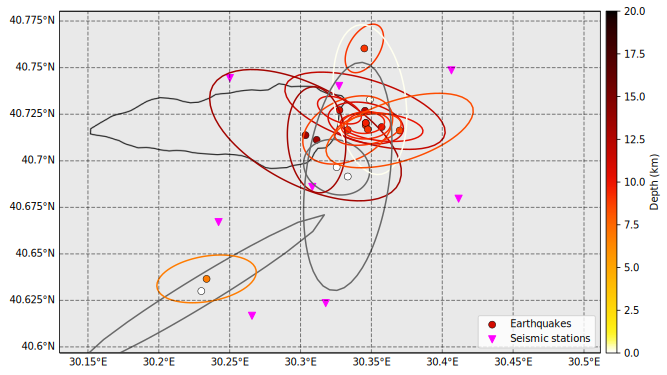

In [23]:
fig = nlloc_catalog.plot_map(
    figsize=(10, 10), network=net, s=50, markersize_station=50, lat_margin=0.02, plot_uncertainties=True
    )
ax = fig.get_axes()[0]
ax.set_facecolor("dimgrey")
ax.patch.set_alpha(0.15)

## Remove possible multiple detections

The backprojection method does not have good inter-event time resolution because of the large uncertainties on the event origin times. There always exists a relatively large trade-off between the origin time and the location so it happens to detect the same event several times in a row if `MINIMUM_INTEREVENT_TIME_SEC` was not set large enough in `5_backprojection.ipynb`. After relocation `NonLinLoc`, it is easier to identify such multiple detections.

In [24]:
# the criteria that determine whether two events are the same or not are of course somewhat arbitrary
# however, one can play with them and see what values effectively discard multiples
MINIMUM_INTEREVENT_TIME_SEC = 5.
MINIMUM_EPICENTRAL_DISTANCE_KM = 10.

In [25]:
keep = np.ones(nlloc_catalog.n_events, dtype=bool)
for i in range(1, nlloc_catalog.n_events):
    previous_ev = i - 1
    while not keep[previous_ev]:
        previous_ev -= 1
        if previous_ev < 0:
            break
    dt_sec = (
        nlloc_catalog.catalog.origin_time[i]
        - nlloc_catalog.catalog.origin_time[previous_ev]
    ).total_seconds()
    if dt_sec < MINIMUM_INTEREVENT_TIME_SEC:
        # test their epicentral distance
        epi_distance = BPMF.utils.two_point_epicentral_distance(
                nlloc_catalog.catalog.iloc[i]["latitude"],
                nlloc_catalog.catalog.iloc[i]["longitude"],
                nlloc_catalog.catalog.iloc[previous_ev]["latitude"],
                nlloc_catalog.catalog.iloc[previous_ev]["longitude"]
                )
        if epi_distance > MINIMUM_EPICENTRAL_DISTANCE_KM:
            # these two events are close in time but distant in space
            continue
        if (
            "NLLoc_reloc" in backprojection_events[i].aux_data
            and "NLLoc_reloc" not in backprojection_events[previous_ev].aux_data
        ):
            keep[previous_ev] = False
        elif (
            "NLLoc_reloc" not in backprojection_events[i].aux_data
            and "NLLoc_reloc" in backprojection_events[previous_ev].aux_data
        ):
            keep[i] = False
        elif backprojection_events[i].hmax_unc < backprojection_events[previous_ev].hmax_unc:
            keep[previous_ev] = False
        elif backprojection_events[i].hmax_unc > backprojection_events[previous_ev].hmax_unc:
            keep[i] = False
        else:
            # if both backprojection_events[i] and backprojection_events[previous_ev] were not relocated with NLLoc,
            # then there origin times cannot be closer than MINIMUM_INTEREVENT_TIME_SEC
            continue


nlloc_catalog.catalog[keep]


,longitude,latitude,depth,origin_time,hmax_unc,hmin_unc,az_hmax_unc,vmax_unc
0,30.345996,40.720312,11.152344,2012-07-26 01:10:21.760,2.279654,1.184107,101.432332,2.431673
1,30.345508,40.726875,11.914062,2012-07-26 01:15:53.520,4.970115,1.854803,107.194478,5.657299
2,30.230000,40.630000,-0.500000,2012-07-26 01:57:56.160,8.657532,0.863562,58.590401,2.744158
3,30.333301,40.716563,8.714844,2012-07-26 02:35:01.240,2.834090,1.812604,64.889447,6.333856
4,30.345020,40.760312,9.019531,2012-07-26 03:00:38.960,1.596869,0.918413,31.198687,2.347905
5,30.303516,40.713750,13.234375,2012-07-26 04:43:38.040,6.265708,2.957693,117.664229,5.721089
6,30.357227,40.718125,10.289062,2012-07-26 04:48:38.320,2.477989,0.819309,96.228056,3.641937
7,30.325488,40.696562,-1.949219,2012-07-26 08:08:25.680,2.006770,1.611699,108.800972,6.092968
8,30.345996,40.719062,9.324219,2012-07-26 10:07:23.600,1.481483,0.810446,87.277455,2.363755
9,30.233691,40.636563,6.785156,2012-07-26 11:55:34.720,3.003351,1.349608,80.171367,2.019324


In [ ]:
nlloc_catalog.catalog[keep].to_csv(
    os.path.join(BPMF.cfg.OUTPUT_PATH, OUTPUT_CSV_FILENAME)
)

## Save the relocated events

Save all the events that were not identified as multiples to a hdf5 database.

In [26]:
for i, ev in enumerate(backprojection_events):
    if keep[i]:
        ev.id = ev.origin_time.strftime("%Y%m%d_%H%M%S")
        ev.write(
            OUTPUT_DB_FILENAME,
            db_path=BPMF.cfg.OUTPUT_PATH,
            gid=ev.id
            )

Found existing event 20120726_011021 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_011553 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_015756 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_023501 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_030038 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_044338 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_044838 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_080825 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_100723 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_115534 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_133527 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Found existing event 20120726_134832 in ../BPMF_outputs/reloc_bp.h5. Overwrite it.
Foun

## Relocation 2 (Bonus): Locating and estimating uncertainties with backprojection on a fine grid

The goal of this section is to explore an alternative to the PhaseNet + NonLinLoc workflow solely based on the use backprojection. If a "sparse" grid was used for the purpose of earthquake detection, then a fine grid can be used here.

In the following, we run a "vanilla" backprojection that backprojects the waveforms' envelopes (as defined by the Hilbert transform).

In [27]:
# PHASES: list of seismic phases to use for backprojection
PHASES = ["P", "S"]
# TT_FILENAME: name of the file with the travel times
TT_FILENAME = "tts.h5"
# N_MAX_STATIONS: the maximum number of stations used for stacking (e.g. the closest to a given grid point)
# note: this parameter is irrelevant in this example with only 8 stations, but it is important when
# using large seismic networks
N_MAX_STATIONS = 10

For backprojection, we need to load the travel time grid and set up the `BPMF.template_search.Beamformer` instance.

In [28]:
# load travel times and the grid point (source) coordinates
tts, source_coords = BPMF.utils.load_travel_times(
    os.path.join(BPMF.cfg.MOVEOUTS_PATH, TT_FILENAME),
    phases=PHASES,
    source_indexes=None,
    return_coords=True,
    stations=net.stations,
)

In [29]:
EVENT_IDX = 0

# initialize a new beamformer because, in general, you might want to use a different
# travel-time table for this beamformer (e.g. denser)
bf_loc = BPMF.template_search.Beamformer(
    tts,
    source_coords,
    sampling_rate=BPMF.cfg.SAMPLING_RATE_HZ,
    phases=PHASES,
    remove_tt_min=True,
)
# here, we need to "trick" the Beamformer instance and give it something similar to the Data instance in 5_backprojection
bf_loc.set_data(backprojection_events[EVENT_IDX])
# attach the Network instance
bf_loc.set_network(net)
# attach weights (the waveform features are the waveforms' envelopes)
# weights_phases = np.ones((net.n_stations, net.n_components, len(PHASES)), dtype=np.float32)
# weights_phases[:, :2, 0] = 0. # P-wave weight = 0 for horizontal components
# weights_phases[:, 2, 1] = 0. # S-wave weight = 0 for vertical components

# uncomment this section to perform the backprojection-based relocation
# with ML waveform features (PhaseNet)
weights_phases = np.ones((net.n_stations, 2, 2), dtype=np.float32)
weights_phases[:, 0, 1] = 0.0  # S-wave weights to zero for channel 0
weights_phases[:, 1, 0] = 0.0  # P-wave weights to zero for channel 1
bf_loc.set_weights_sources(N_MAX_STATIONS)
bf_loc.set_weights(weights_phases=weights_phases)

In [30]:
# relocation parameters
LOCATION_ROUTINE = "beam"
RESTRICTED_DOMAIN_FOR_UNC_KM = 100.
DATA_FOLDER = "preprocessed_2_12"


In [31]:
# uncomment this section to perform the backprojection-based relocation
# with ML waveform features (PhaseNet)

import torch
import seisbench.models as sbm

beam_relocated_event = copy.deepcopy(backprojection_events[EVENT_IDX])
ml_detector = sbm.PhaseNet.from_pretrained("original")
ml_detector.eval()

beam_relocated_event.read_waveforms(
    120., offset_ot=40., time_shifted=False,
    data_folder="preprocessed_2_12", data_reader=data_reader_mseed
)

data_arr = beam_relocated_event.get_np_array(net.stations)

data_arr_n = BPMF.utils.normalize_batch(data_arr)
closest_pow2 = int(np.log2(data_arr_n.shape[-1])) + 1
diff = 2**closest_pow2 - data_arr_n.shape[-1]
left = diff//2
right = diff//2 + diff%2
data_arr_n = np.pad(
        data_arr_n,
        ((0, 0), (0, 0), (left, right)),
        mode="reflect"
        )


with torch.no_grad():
    PN_probas = ml_detector(
        torch.from_numpy(data_arr_n).float()
    )
# remove channel 0 that is probability of noise
waveform_features = PN_probas[:, 1:, :].detach().numpy()


In [32]:
beam_relocated_event = copy.deepcopy(backprojection_events[EVENT_IDX])

# beam_relocated_event.relocate(
#     routine=LOCATION_ROUTINE,
#     duration=120.,
#     offset_ot=40.,
#     beamformer=bf_loc,
#     data_folder=DATA_FOLDER,
#     restricted_domain_side_km=RESTRICTED_DOMAIN_FOR_UNC_KM,
#     data_reader=data_reader_mseed,
# )

# uncomment this section if you are using ML waveform features
beam_relocated_event.relocate(
    routine=LOCATION_ROUTINE,
    beamformer=bf_loc,
    data_folder=DATA_FOLDER,
    restricted_domain_side_km=RESTRICTED_DOMAIN_FOR_UNC_KM,
    data_reader=data_reader_mseed,
    waveform_features=waveform_features
)

In [33]:
dummy_catalog = BPMF.dataset.Catalog.read_from_events(
    [backprojection_events[EVENT_IDX]],
    extra_attributes=["hmax_unc", "hmin_unc", "az_hmax_unc", "vmax_unc"]
    )
dummy_catalog.catalog["az_hmax_unc"] = dummy_catalog.catalog["az_hmax_unc"]%180.
dummy_catalog.catalog

,longitude,latitude,depth,origin_time,hmax_unc,hmin_unc,az_hmax_unc,vmax_unc
0,30.345996,40.720312,11.152344,2012-07-26 01:10:21.760,2.279654,1.184107,101.432332,2.431673


The difference between this backprojection and the "detection backprojection" of 5_backprojection is that, here, we stored the value of each beam of the 4D (x, y, z, time) grid! Below, we plot 3 slices of the (x, y, z, time=time of max beam) volume.

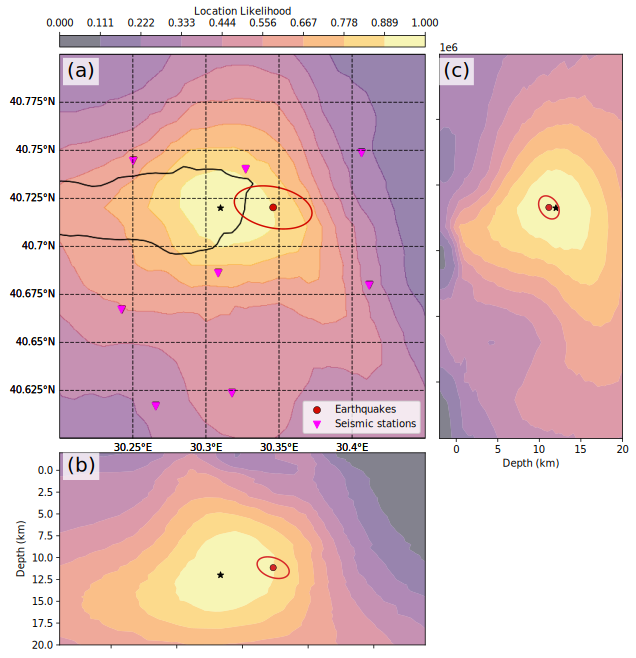

In [34]:
from cartopy.crs import PlateCarree

scatter_kwargs = {}
scatter_kwargs["edgecolor"] = "k"
scatter_kwargs["linewidths"] = 0.5
scatter_kwargs["s"] = 40
scatter_kwargs["zorder"] = 3
scatter_kwargs["color"] = "C3"



# when using the beam-based relocation routine, the entire grid of beams is stored in memory
fig_beam_reloc = bf_loc.plot_likelihood(figsize=(15, 11), likelihood=bf_loc.likelihood)
axes = fig_beam_reloc.get_axes()
fig_beam_reloc = dummy_catalog.plot_map(
    ax=axes[0], network=net, s=50, markersize_station=50, lat_margin=0.02, plot_uncertainties=True, depth_colorbar=False
    )

# the following is a bit cumbersome and is just to plot the uncertainty ellipses on the depth cross-sections
ax = axes[0]
data_coords = PlateCarree()
projected_coords_nlloc = ax.projection.transform_points(
    data_coords,
    np.array([backprojection_events[EVENT_IDX].longitude]),
    np.array([backprojection_events[EVENT_IDX].latitude]),
)
projected_coords_backproj = ax.projection.transform_points(
    data_coords,
    np.array([beam_relocated_event.longitude]),
    np.array([beam_relocated_event.latitude]),
)

ax.scatter(
    beam_relocated_event.longitude,
    beam_relocated_event.latitude,
    marker="*",
    s=40,
    color="k",
    label="Initial backprojection location",
    transform=data_coords
)

axes[1].scatter(
    projected_coords_nlloc[0, 0], backprojection_events[EVENT_IDX].depth, **scatter_kwargs
)
axes[1].scatter(
    projected_coords_backproj[0, 0],
    initial_catalog.catalog.loc[EVENT_IDX, "depth"],
    marker="*",
    s=40,
    color="k",
)
ew_ellipse_lon, ew_ellipse_lat, ew_ellipse_dep = BPMF.plotting_utils.vertical_uncertainty_ellipse(
    backprojection_events[EVENT_IDX].aux_data["cov_mat"],
    backprojection_events[EVENT_IDX].longitude,
    backprojection_events[EVENT_IDX].latitude,
    backprojection_events[EVENT_IDX].depth,
    horizontal_direction="longitude"
)
projected_ellipse_coords = ax.projection.transform_points(
    data_coords,
    ew_ellipse_lon,
    ew_ellipse_lat,
)
axes[1].plot(
    projected_ellipse_coords[:, 0], ew_ellipse_dep, color=scatter_kwargs["color"]
)

axes[2].scatter(
    backprojection_events[EVENT_IDX].depth, projected_coords_nlloc[0, 1], **scatter_kwargs
)
axes[2].scatter(
    initial_catalog.catalog.loc[EVENT_IDX, "depth"],
    projected_coords_backproj[0, 1],
    marker="*",
    s=40,
    color="k",
)
ns_ellipse_lon, ns_ellipse_lat, ns_ellipse_dep = BPMF.plotting_utils.vertical_uncertainty_ellipse(
    backprojection_events[EVENT_IDX].aux_data["cov_mat"],
    backprojection_events[EVENT_IDX].longitude,
    backprojection_events[EVENT_IDX].latitude,
    backprojection_events[EVENT_IDX].depth,
    horizontal_direction="latitude"
)
projected_ellipse_coords = ax.projection.transform_points(
    data_coords,
    ns_ellipse_lon,
    ns_ellipse_lat,
)
axes[2].plot(
    ns_ellipse_dep, projected_ellipse_coords[:, 1], color=scatter_kwargs["color"]
)

axes[1].set_ylim(20., axes[1].get_ylim()[1])
axes[2].set_xlim(axes[2].get_xlim()[0], 20.)

for i, ax in enumerate(axes[:-1]):
    ax.text(0.02, 0.98, f'({string.ascii_lowercase[i]})', va='top',
            fontsize=20, ha='left', bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.75},
            transform=ax.transAxes)  

The current way of estimating location uncertainties with the backprojection method is to compute a weighted average distance between the maximum beam grid point (indexed by $k^*$) and all other grid points. To avoid the result to be grid-size dependent, we limit the weighted average to a restricted rectangular domain taken around the maximum beam grid point.
$$ h_{unc} = \dfrac{L_k e_{i,k^*}}{\sum_{k \in \mathcal{R}} L_k},$$
$$ v_{unc} = \dfrac{L_k \Delta d_{i,k^*}}{\sum_{k \in \mathcal{R}} L_k},$$
where $e_{i,k^*}$ is the epicentral distance between grid points $i$ and $k^*$ and $\Delta d_{i,k^*}$ is the depth difference between grid points $i$ and $k^*$.

In this case, we assume the uncertainty ellipse to be isotropic, that is, $h_{max,unc} = h_{min,unc}$.

In [35]:
EVENT_IDX = 0
ev = backprojection_events[EVENT_IDX]
print(f"The maximum horizontal location uncertainty of event {EVENT_IDX} is {ev.hmax_unc:.2f}km.")
print(f"The azimuth of the maximum horizontal uncertainty is {ev.az_hmax_unc:.2f}degrees.")
print(f"The mainimum horizontal location uncertainty of event {EVENT_IDX} is {ev.hmin_unc:.2f}km.")
print(f"The azimuth of the minimum horizontal uncertainty is {ev.az_hmin_unc:.2f}degrees.")
print(f"The maximum vertical location uncertainty is {ev.vmax_unc:.2f}km with {ev._pl_vmax_unc%90:.2f}degrees plunge.")

The maximum horizontal location uncertainty of event 0 is 2.28km.
The azimuth of the maximum horizontal uncertainty is 101.43degrees.
The mainimum horizontal location uncertainty of event 0 is 1.18km.
The azimuth of the minimum horizontal uncertainty is 11.43degrees.
The maximum vertical location uncertainty is 2.43km with 47.42degrees plunge.
